In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from pathlib import Path
from regions import CircleSkyRegion, RectangleSkyRegion
from astropy.coordinates import SkyCoord
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModels
)
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.data import DataStore
from gammapy.maps import WcsGeom, MapAxis
from gammapy.cube import MapDatasetMaker, MapDataset, SafeMaskMaker

%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from pathlib import Path
from regions import CircleSkyRegion
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyDiffuseCube,
    SkyModels
)
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.data import DataStore
from gammapy.maps import WcsGeom, MapAxis
from gammapy.cube import MapDatasetMaker, MapDataset, SafeMaskMaker

In [2]:
config = AnalysisConfig()
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
                energy_true: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background: {method: reflected, exclusion: null}
        on_region: {frame: null, lon: null, lat: null, ra

In [23]:
# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64"
config.observations.obs_cone ={"frame": "galactic" , "lon": "0.0 deg", "lat":"0.01 deg", "radius": "6 deg"}

#ca c'est vide pour l'instant car on est dans la section observations du fichier de config 
print(config.observations.obs_ids)

#selected_obs_table = data_store.obs_table.select_observations(selection)
#observations = data_store.get_observations(selected_obs_table["OBS_ID"])

[]


In [24]:
config.datasets.type = "3d"  

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
    
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.fov = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV offset cut
config.datasets.geom.selection.offset_max = 2.0 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "50 TeV"
config.datasets.geom.axes.energy.nbins = 20

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true enery binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "70 TeV"
config.datasets.geom.axes.energy_true.nbins = 30



In [26]:
#select observations 

config.datasets.stack = True
analysis_stacked = Analysis(config)

# select observations:
analysis_stacked.get_observations()

#analysis.observations c'est deja une liste d'observations et on est deja plus dans la table datastore
#donc je peux faire des filtres encore a ce stade mais en utilisant la liste des obs (soit une boucle sur les obs, soit je coupe la liste aux X premiers membres)
selected_obs=analysis_stacked.observations[:3000]
#print(selected_obs)
#analysis_stacked.observations=selected_obs
#print(analysis_stacked.observations)

obs_IRFs=[]
for obs in selected_obs:
        try: 
            obs.aeff
            obs.bkg
            #obs.psf
            obs_IRFs.append(obs)
        except Exception:
            print(" Cut run number: ",obs.obs_id)
            #cut_list.append(obs.obs_id)
            #list_id.remove(obs.obs_id)   
            continue
            
print(len(obs_IRFs))           
observations=obs_IRFs

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 1782


 Cut run number:  31539
 Cut run number:  31577
 Cut run number:  31578
 Cut run number:  31579
 Cut run number:  31580
 Cut run number:  31624
1776


In [27]:
##FoV background estimation
import logging
from gammapy.maps import Map
from gammapy.modeling import Fit, Datasets


class FoVBackgroundMaker:
    """Normalize template background on the whole field-of-view.

    The dataset background model can be simply scaled (method="scale") or fitted (method="fit")
    on the dataset counts.

    The normalization is performed outside the exclusion mask that is passed on init.

    If a SkyModel is set on the input dataset and method is 'fit', its are frozen during
    the fov normalization fit.

    Parameters
    ----------
    method : str in ['fit', 'scale']
        the normalization method to be applied. Default 'scale'.
    exclusion_mask : `~gammapy.maps.WcsNDMap`
        Exclusion mask
    """

    def __init__(self, method="scale", exclusion_mask=None):
        if method in ["fit", "scale"]:
            self.method = method
        else:
            raise ValueError(f"Incorrect method for FoVBackgroundMaker: {method}.")
        self.exclusion_mask = exclusion_mask


    def run(self, dataset):
        """Run FoV background maker.

        Fit the background model norm

        Parameters
        ----------
        dataset : `~gammapy.cube.fit.MapDataset`
            Input map dataset.

        """
        mask_fit = dataset.mask_fit
        dataset.mask_fit = self._reproject_exclusion_mask(dataset)

        if self.method is "fit":
            self._fit_bkg(dataset)
        else:
            self._scale_bkg(dataset)

        dataset.mask_fit = mask_fit
        return dataset


    def _reproject_exclusion_mask(self, dataset):
        """Reproject the exclusion on the dataset geometry"""
        mask_map = Map.from_geom(dataset.counts.geom)
        if self.exclusion_mask is not None:
            coords = dataset.counts.geom.get_coord()
            vals = self.exclusion_mask.get_by_coord(coords)
            mask_map.data += vals

        return mask_map.data.astype("bool")

    def _fit_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""

        # freeze all model components not related to background model
        datasets = Datasets([dataset])

        parameters_frozen = []
        for par in datasets.parameters:
            parameters_frozen.append(par.frozen)
            if par not in dataset.background_model.parameters:
                par.frozen = True

        fit = Fit(datasets)
        fit_result = fit.run()
        if fit_result.success is False:
            log.info(
                f"FoVBackgroundMaker failed. No fit convergence for {dataset.name}."
            )

        # Unfreeze parameters
        for i, par in enumerate(datasets.parameters):
            par.frozen = parameters_frozen[i]

    def _scale_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""
        mask = dataset.mask
        count_tot = dataset.counts.data[mask].sum()
        bkg_tot = dataset.background_model.map.data[mask].sum()

        if count_tot <= 0.0:
            log.info(
                f"FoVBackgroundMaker failed. No counts found outside exclusion mask for {dataset.name}."
            )
        elif bkg_tot <= 0.0:
            log.info(
                f"FoVBackgroundMaker failed. No positive background found outside exclusion mask for {dataset.name}."
            )
        else:
            scale = count_tot / bkg_tot
            dataset.background_model.norm.value = scale



In [28]:
config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
    
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.fov = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV offset cut
config.datasets.geom.selection.offset_max = 2.0 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "50 TeV"
config.datasets.geom.axes.energy.nbins = 13

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true enery binning)
print(config.datasets.geom.axes.energy_true)
ereco_axis = MapAxis.from_energy_bounds(0.1,50, 13, unit='TeV')
etrue_axis = MapAxis.from_energy_bounds(0.08, 70., 20, unit='TeV')
center = SkyCoord(0, 0, frame='galactic', unit='deg')

geom = WcsGeom.create(skydir=center, width=['12 deg', '8 deg'], coordsys='GAL', binsz=0.02, axes=[ereco_axis])


min=<Quantity 0.08 TeV> max=<Quantity 70. TeV> nbins=30


In [29]:
spatial_model_ridge = PointSpatialModel(lon_0="0.0 deg", lat_0="0.04 deg", frame="galactic")
spatial_model_S1 = PointSpatialModel(lon_0="3.75 deg", lat_0="1.8 deg", frame="galactic")
spatial_model_GC = PointSpatialModel(lon_0="0.0 deg", lat_0="0.0 deg", frame="galactic")
region1=RectangleSkyRegion(center=spatial_model_ridge.position, height=2.0 * u.deg,width=10.0 * u.deg)
region2=CircleSkyRegion(center=spatial_model_S1.position, radius=0.28 * u.deg)
region3=CircleSkyRegion(center=spatial_model_GC.position, radius=2.0 * u.deg)
exclusion_mask = Map.from_geom(geom, data=geom.region_mask([region1,region2,region3], inside=False)) 


(<Figure size 432x288 with 1 Axes>,
 None)

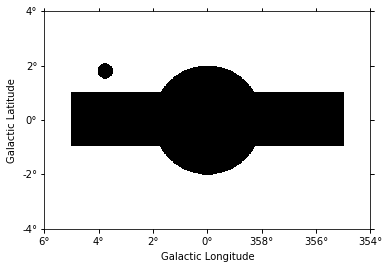

In [30]:
exclusion_mask.sum_over_axes().plot()

In [31]:
#for obs in observations:
#    print(obs)

In [ ]:
## run data reduction with high level tool
#analysis_stacked.get_datasets()

#run data reduction by hand
#geom=analysis_stacked.datasets[0].geom


analysis_stacked = MapDataset.create(geom=geom, energy_axis_true=etrue_axis, name="GC-stacked")

#data reduction

#Create the maker class to be used 
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=config.datasets.geom.selection.offset_max)
maker_bkg = FoVBackgroundMaker("scale",exclusion_mask)
                               
#data reduction loop
for obs in observations:
         
    #print(obs.obs_id)
    # First a cutout of the target map is produced
    cutout = analysis_stacked.cutout(obs.pointing_radec, width=2 * config.datasets.geom.selection.offset_max)
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
   
    #normalize the Bg out of exclusion mask
    dataset=maker_bkg.run(dataset)
    
    # The resulting dataset cutout is stacked onto the final one
    analysis_stacked.stack(dataset)



#je recupere le dataset
dataset_stacked = analysis_stacked

##keep the data dataset to normalize the background and compare with simulation
DATA_dataset_stacked=dataset_stacked.copy()


In [ ]:
dataset_stacked.background_model.map.sum_over_axes().plot()

In [ ]:
DATA_dataset_stacked.counts.sum_over_axes().smooth(0.07 * u.deg).plot(stretch="sqrt", add_cbar=True)

In [ ]:
DATA_dataset_stacked.background_model.evaluate().sum_over_axes().plot(stretch="sqrt",add_cbar=True)

In [ ]:
excess_map=DATA_dataset_stacked.counts.sum_over_axes() - DATA_dataset_stacked.background_model.evaluate().sum_over_axes()
excess_map.smooth(0.1 * u.deg).plot(stretch="sqrt",add_cbar=True, vmin=-1, vmax=20)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (600, 400, 2)
	ndim  : 3
	unit  : 
	dtype : float64

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (600, 400, 3)
	ndim  : 3
	unit  : 
	dtype : float64

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (600, 400, 3)
	ndim  : 3
	unit  : 
	dtype : float64



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12544bb70>)

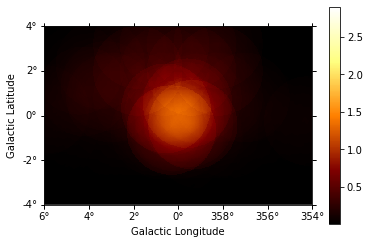

In [16]:
#excess_map.write("HESS_GC_5deg_Excess_Cube.fits")
#DATA_dataset_stacked.write("DATA_Set_GC_5deg_Cube.fits")
First_E_band=DATA_dataset_stacked.counts.slice_by_idx({'energy': slice(3, 5)})
Second_E_band=DATA_dataset_stacked.counts.slice_by_idx({'energy': slice(6, 9)})
Third_E_band=DATA_dataset_stacked.counts.slice_by_idx({'energy': slice(10, 13)})

#prendre le background comme ca marche que si la dependance en E (tilt) est conforme 
#aux donnees car le Bg model est fite sur l'ensemble des counts.
# augmenter les bins pour les effets de seuil
# fiter le (le mettre libre) tilt quand je scale le bg sur les data
First_E_bkg=DATA_dataset_stacked.background_model.evaluate().slice_by_idx({'energy': slice(3, 5)})
Second_E_bkg=DATA_dataset_stacked.background_model.evaluate().slice_by_idx({'energy': slice(6, 9)})
Third_E_bkg=DATA_dataset_stacked.background_model.evaluate().slice_by_idx({'energy': slice(10, 13)})

print(First_E_bkg)
print(Second_E_bkg)
print(Third_E_bkg)

First_E_excess=First_E_band.sum_over_axes() - First_E_bkg.sum_over_axes()
Second_E_excess=Second_E_band.sum_over_axes() - Second_E_bkg.sum_over_axes()
Third_E_excess=Third_E_band.sum_over_axes() - Third_E_bkg.sum_over_axes()

#First_E_bkg.sum_over_axes().plot(stretch="sqrt", add_cbar=True)
#Second_E_bkg.sum_over_axes().plot(stretch="linear", add_cbar=True)
Third_E_bkg.sum_over_axes().plot(stretch="linear", add_cbar=True,vmax=2.9)

#First_E_excess.write("LE_HESS_CG_5deg_excess.fits")
#Second_E_excess.write("ME_HESS_CG_5deg_excess.fits")
#Third_E_excess.write("HE_HESS_CG_5deg_excess.fits")

In [17]:
bkg=DATA_dataset_stacked.background_model.norm.value
print(bkg)
bkg_3=DATA_dataset_stacked.background_model.evaluate().slice_by_idx({'energy': 3})
print(bkg_3)

1.0
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (600, 400)
	ndim  : 2
	unit  : 
	dtype : float64



In [18]:
#Define model Simu
#model_simu = SkyModel("/Users/alemiere/GAMMA_PI/gammapy-tutorials/datasets/1dc/models/cube_iem.fits.gz")
model_simu = SkyDiffuseCube.read("/Users/alemiere/GAMMA_PI/gammapy-tutorials/datasets/1dc/models/cube_iem.fits.gz")
#model_simu = SkyDiffuseCube.read("/Users/alemiere/GAMMA_PI/gammapy-tutorials/datasets/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz")
print(model_simu)

SkyDiffuseCube

   name     value   error unit min max frozen
--------- --------- ----- ---- --- --- ------
     norm 1.000e+00   nan      nan nan  False
     tilt 0.000e+00   nan      nan nan   True
reference 1.000e+00   nan  TeV nan nan   True


In [19]:
model_simu.norm.value=0.3
##model_simu.parameters['norm']=0.9
model_simu.norm.frozen=True
print(model_simu)

SkyDiffuseCube

   name     value   error unit min max frozen
--------- --------- ----- ---- --- --- ------
     norm 3.000e-01   nan      nan nan   True
     tilt 0.000e+00   nan      nan nan   True
reference 1.000e+00   nan  TeV nan nan   True


In [20]:
# on ne comprend pas pourquoi il faut faire cette manip au vol puisque skydiffusecube est par def un skymodel
models = SkyModels([model_simu])

In [21]:
# Add the model on the dataset and Poission fluctuate
dataset_stacked.models = models
dataset_stacked.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset_stacked)

/Users/alemiere/anaconda2/envs/gammapy-0.15/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/alemiere/anaconda2/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


MapDataset

    Name                            : GC-stacked 

    Total counts                    : 1201920 
    Total predicted counts          : 1199794.31
    Total background counts         : 1156429.92

    Exposure min                    : 0.00e+00 m2 s
    Exposure max                    : 8.19e+11 m2 s

    Number of total bins            : 3120000 
    Number of fit bins              : 3120000 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : 1083489.75

    Number of models                : 2 
    Number of parameters            : 6
    Number of free parameters       : 1

    Component 0: 
        Name                        : cube_iem.fits
        Type                        : SkyDiffuseCube
        Parameters:
            norm         (frozen)   : 0.300  
            tilt         (frozen)   : 0.000  
            reference    (frozen)   : 1.000  TeV

    Component 1: 
        Name                        : background
        Type            

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11e1a6908>)

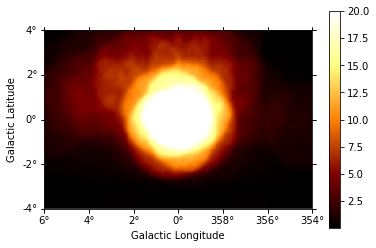

In [22]:
#look at the simulated counts map
dataset_stacked.counts.sum_over_axes().smooth(0.1 * u.deg).plot(stretch="linear", add_cbar=True,vmax=20)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11fc6eeb8>)

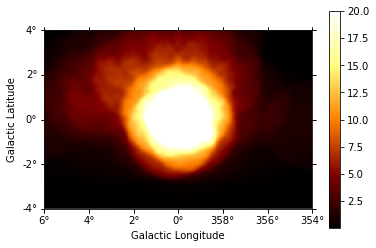

In [23]:
DATA_dataset_stacked.counts.sum_over_axes().smooth(0.1 * u.deg).plot(stretch="linear", add_cbar=True,vmax=20)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12099c828>)

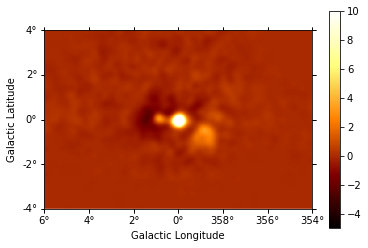

In [24]:
sub_maps = DATA_dataset_stacked.counts.sum_over_axes() - dataset_stacked.counts.sum_over_axes()
sub_maps.smooth(0.15 * u.deg).plot(stretch="linear", add_cbar=True, vmin=-5, vmax=10)

In [25]:
## rajouter du temps d'observation :
livetime = 100.0 * u.hr

data_store = DataStore.from_dir("/Users/alemiere/GAMMA_PI/Prod_2019_V015/he_stereo_Prod17_Calib0834_thsq64/")
#selected_obs_table = data_store.obs_table.select_observations(selection)
#obs = data_store.get_observations(selected_obs_table["OBS_ID"])
#run de 2018 qui un pas mal place
#list_ids=[138961]
#list_ids=[138962]
#list_ids=[149948]
list_ids=[150101]
obs=data_store.get_observations(list_ids)[0]
#attention ici, ce run est trop vieux !! il faut faire avec un run HESS1U

print(obs)

irfs={}
#irfs["bkg"] = obs.bkg
irfs["aeff"] = obs.aeff
irfs["psf"] = obs.psf
irfs["edisp"] = obs.edisp
irfs["bkg"] = obs.bkg 

from gammapy.data import Observation

pointing = SkyCoord(2.57, 1.06, unit="deg", frame="galactic")

# Create an in-memory observation
Simu_New_obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(Simu_New_obs)



# Make the MapDataset
empty = MapDataset.create(geom)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.5 * u.deg)
dataset = maker.run(empty, Simu_New_obs)
dataset = maker_safe_mask.run(dataset, Simu_New_obs)
#print(dataset)

# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
print(dataset)
# pour le bakground, il faut le prendre dans 3-4 runs : 

Info for OBS_ID = 150101
- Start time: 51910.68
- Pointing pos: RA 267.38 deg / Dec -25.96 deg
- Observation duration: 1681.0 s
- Dead-time fraction: 1.277 %

Info for OBS_ID = 1
- Pointing pos: RA 266.89 deg / Dec -26.19 deg
- Livetime duration: 360000.0 s



/Users/alemiere/anaconda2/envs/gammapy-0.15/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/alemiere/anaconda2/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


MapDataset

    Name                            : obs_1 

    Total counts                    : 284637 
    Total predicted counts          : 284394.14
    Total background counts         : 275318.46

    Exposure min                    : 2.44e+00 m2 s
    Exposure max                    : 1.95e+11 m2 s

    Number of total bins            : 3120000 
    Number of fit bins              : 638326 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : 580838.73

    Number of models                : 2 
    Number of parameters            : 6
    Number of free parameters       : 1

    Component 0: 
        Name                        : cube_iem.fits
        Type                        : SkyDiffuseCube
        Parameters:
            norm         (frozen)   : 0.300  
            tilt         (frozen)   : 0.000  
            reference    (frozen)   : 1.000  TeV

    Component 1: 
        Name                        : background
        Type                      

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11f8c6e80>)

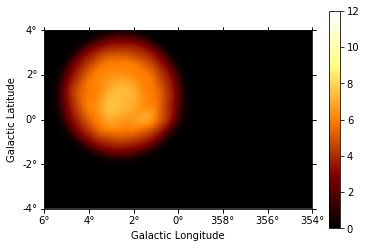

In [26]:
#look at the simulated counts map
dataset.counts.sum_over_axes().smooth(0.2 * u.deg).plot(stretch="linear", add_cbar=True, vmax=12)
#dataset.background_model.evaluate().sum_over_axes().plot(add_cbar=True)

In [27]:
#add data_simulated_map and new_data_simulated_map :
#Final_dataset = dataset_stacked.counts.sum_over_axes() + dataset.counts.sum_over_axes()
Final_dataset=dataset_stacked.copy()
#Final_dataset=Final_dataset.stack(dataset)
#marche pas car on ne peut stacker que des cartes avec le meme cutout

Final_dataset.sum_over_axes().smooth(0.1 * u.deg).plot(stretch="linear", add_cbar=True, vmax=32)

AttributeError: 'MapDataset' object has no attribute 'sum_over_axes'

In [ ]:
Final_dataset.write('Total_simu_50h.fits', hdu='IMAGE')

In [ ]:
dataset.counts.sum_over_axes().write('NewObs_simu_50h.fits', hdu='IMAGE')

In [ ]:
dataset_stacked.counts.sum_over_axes().write('FromDataObs_simu.fits', hdu='IMAGE')

In [ ]:
DATA_dataset_stacked.counts.sum_over_axes().write('DataObs.fits', hdu='IMAGE')

In [ ]:
from astropy.convolution import Tophat2DKernel 
from gammapy.detect import compute_lima_image
#il me faut des cartes en significativité ?...
scale = geom.pixel_scales[0].to("deg")
theta = 0.2 * u.deg / scale
tophat = Tophat2DKernel(theta)
tophat.normalize("peak")

ds=DATA_dataset_stacked.to_image()
lima_Data = compute_lima_image(ds.counts,ds.background_model.evaluate(),tophat)
ds_sim = dataset_stacked.to_image()
lima_Simu_OnData = compute_lima_image(ds_sim.counts,ds_sim.background_model.evaluate(),tophat)
ds_sim_new = dataset.to_image()
lima_SimuNew = compute_lima_image(ds_sim_new.counts,ds_sim_new.background_model.evaluate(),tophat)

#ds_tot = Final_dataset.to_image()
#lima_SimuTotal= compute_lima_image(ds_tot.counts,ds_tot.background_model.evaluate(),tophat)

In [ ]:
lima_Data['significance'].sum_over_axes().plot( add_cbar=True, vmin=-3, vmax=15)

In [ ]:
lima_Data['significance'].write("Significance_GC_5deg.fits")

In [ ]:
lima_SimuNew['significance'].sum_over_axes().plot(add_cbar=True, vmin=-3, vmax=12)

In [ ]:
lima_Simu_OnData['significance'].sum_over_axes().plot(add_cbar=True, vmin=-3, vmax=15)

In [ ]:
ds_sim.exposure.sum_over_axes().plot(add_cbar=True)

In [ ]:
flux_Datamap = lima_Data['excess'].sum_over_axes() / ds.exposure.sum_over_axes()
flux_SimuOnData= lima_Simu_OnData['excess'].sum_over_axes() / ds_sim.exposure.sum_over_axes()
flux_NewSimu= lima_SimuNew['excess'].sum_over_axes() / ds_sim_new.exposure.sum_over_axes()

In [ ]:
flux_Datamap.plot(add_cbar=True, vmin=-0.000000015, vmax=0.000000075)

In [ ]:
flux_SimuOnData.plot(add_cbar=True, vmin=-0.000000015, vmax=0.000000075)

In [ ]:
flux_NewSimu.plot(add_cbar=True, vmin=-0.000000015, vmax=0.000000075)